## Assignment 10 Submission

In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import pytensor.tensor as pt
import seaborn as sns
from scipy import stats

### Q1

#### Gaussian Processes (GPs) and Stochastic Processes

Stochastic Process is the sequence of random variables in which usually indexed by time. The random variables are produced based on certain disitribution or potential outcomes, as opposed to deterministic outcomes. The stochastic process can also be viewed as a probability disitrbution over a space as time (index) goes by.

Gaussian Process is a stochastic process where each random variable follow multivariate normal distribution. Alternatively, Gaussian process can be viewed as a generalization of multivariate normal distribution with several variables to infinitely many variables. Like any other gaussian distribution, GPs can be describe by a) the mean function and b) the covariance function. GPs are very useful tool when we are trying to fit a certain set of points from the data. Also, GPs can be specified as prior in Bayesian inference.

#### Variational Inference using Evidence Lower Bound (ELBO) 

Variational Inference is an alternative sampling method to the MCMC algorithm to address the problem of very complex posterior disitrbutions which MCMC performs poorly (sometimes need to sample a lot of data in order to converge to the target distribution). The idea of variational inference is to come up with a nicer from of a disitrbution that is also close to our target distribution, and then sample from the nicer distribution instead. We can see that variational inference is an optimization problem instead of inference problem because we need to find the best disitribution that are closest to the posterior distribution.

Evidence Lower Bound (ELBO) is the lower bound of the log-likelihood of the evidence. Note that in Bayes' theorem, $p(\theta|x) = \frac{p(x|\theta)p(\theta)}{p(x)}$ $\rightarrow$ $p(x)$ is the evidence.

ELBO can be determining the best distribution to sample from in variational inference. Suppose $p$ is the (target) posterior distribution and $q$ is the simpler disitribution we wish to optimize. The distribution $q$ can be obtained through 
\begin{align*}
\log p(x) &= KL(q||p) - \mathbb{E}[\log q(\theta) - \log p(x, \theta)] \\ 
    &= KL(q||p) - \mathcal{L}(q) \\
    &\leq - \mathcal{L}(q) &\text{(Since KL-divergence always greater than or equal to 0)}
\end{align*}
Since $p(x)$ is a constant, then minimizing the ELBO, $\mathcal{L}(q)$ (which is computable through proper choice of $q$) is equivalent to minimizing $KL(q||p)$, which means that we can obtain $q$ such that it is closest simple distribution to $p$.

### Q2

We will perform Gaussian Process smoothing model.

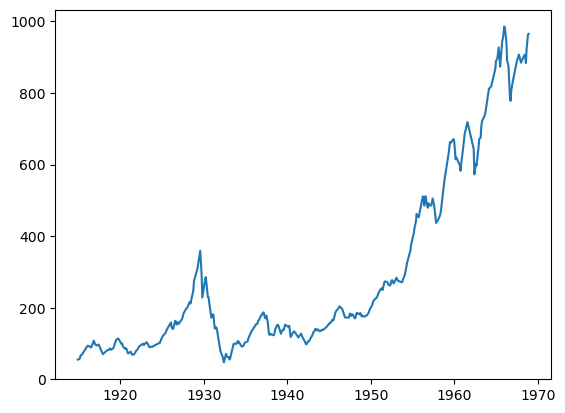

In [44]:
df = sns.load_dataset("dowjones")
df = df.sample(frac = 0.5).sort_values(by = "Date") # Downsample to see more impact of smoothing
x = df["Date"].to_numpy()
y = df["Price"].to_numpy()
plt.plot(x, y)

In [45]:
from pytensor import shared

with pm.Model() as smoothing_model:
    smoothing_param = shared(0.9)
    mu = pm.Normal("mu", sigma = 1e5)
    tau = pm.Exponential("tau", lam = 1e-5)
    z = pm.GaussianRandomWalk("z", mu=mu, sigma=pm.math.sqrt((1-smoothing_param) / tau), shape = y.shape)
    obs = pm.Normal("obs", mu=z, tau=tau/smoothing_param, observed=y)

c:\Users\lotto\anaconda3\envs\pymc_env\Lib\site-packages\pymc\distributions\timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


In [46]:
def smoothing_inference(smoothing):
    with smoothing_model:
        smoothing_param.set_value(smoothing)
        res = pm.find_MAP(vars = [z], method="L-BFGS-B")
    return res["z"]

Output()

Output()

Output()

Output()

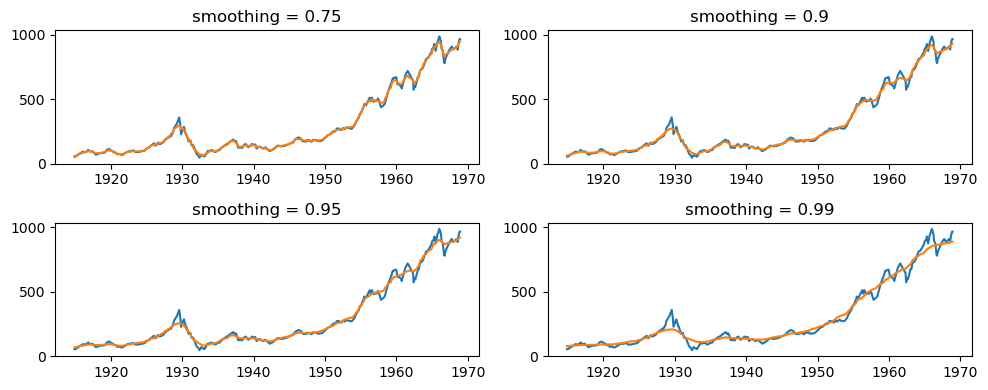

In [61]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 4))

for i, sm in enumerate([0.75, 0.9, 0.95, 0.99]):
    ax[i//2][i%2].plot(x,y)
    ax[i//2][i%2].plot(x, smoothing_inference(sm))
    ax[i//2][i%2].set_title(f"smoothing = {sm}")
plt.tight_layout()

We can see that the less smoothing parameter is, the smoothed curve is more similar to the true value. This implementation is very useful if we want to make the data more smooth. However, setting a very high smoothing parameter many take away some representation of the data (see smoothing = 0.99 as an example). From the result, the smoothed curve is able to capture the noise and hidden process uncertainty very nicely.

### Q3

Dataset are brought from https://www.kaggle.com/datasets/kylegraupe/simulation-generated-dataset-binary-class.

In [162]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import pytensor

floatX = pytensor.config.floatX
rng = np.random.default_rng(1234)
batch_size = 20
n_hidden = 5

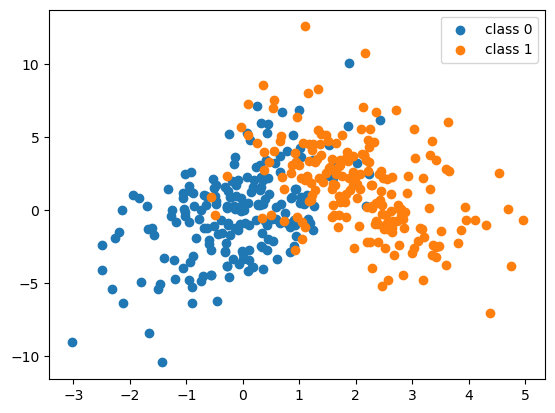

In [163]:
df = pd.read_csv("./../generated_test.csv", header = None, names = ["x1", "x2", "y"])
X = df[["x1", "x2"]].to_numpy().astype(floatX)
Y = df["y"].to_numpy().astype(floatX)
plt.scatter(df[df["y"] == 0]["x1"], df[df["y"] == 0]["x2"], label = "class 0")
plt.scatter(df[df["y"] == 1]["x1"], df[df["y"] == 1]["x2"], label = "class 1")
plt.legend()

In [164]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.4)

Output()

Finished [100%]: Average Loss = 12.352


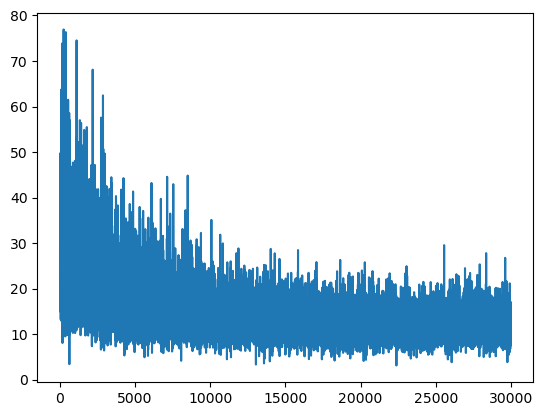

In [165]:
"""
    building Neural Network

"""
l1 = rng.standard_normal(size = (X_train.shape[1], n_hidden)).astype(floatX)
l2 = rng.standard_normal(size = (n_hidden, n_hidden)).astype(floatX)
l3 = rng.standard_normal(size = n_hidden).astype(floatX)

coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "train_cols": np.arange(X_train.shape[1]),
        "obs_id": np.arange(X_train.shape[0])
    }

with pm.Model(coords = coords) as nn:
    X_data = pm.Data("X_data", X_train, dims = ("obs_id", "train_cols"))
    Y_data = pm.Data("Y_data", Y_train, dims = "obs_id")
    ann_input, ann_output = pm.Minibatch(X_data, Y_data, batch_size=batch_size)
    wi1 = pm.Normal("wi1", mu=0, sigma=1, initval=l1, dims=("train_cols", "hidden_layer_1"))
    w12 = pm.Normal("w12", mu=0, sigma=1, initval=l2, dims=("hidden_layer_1", "hidden_layer_2"))
    w2o = pm.Normal("w2o", mu=0, sigma=1, initval=l3, dims="hidden_layer_2")

    # activation function
    act1 = pm.math.tanh(pm.math.dot(ann_input, wi1))
    act2 = pm.math.tanh(pm.math.dot(act1, w12))
    act3 = pm.math.sigmoid(pm.math.dot(act2, w2o))

    out = pm.Bernoulli("out", p = act3, observed = ann_output, total_size = X_train.shape[0])
    idata = pm.fit(n=30000)
plt.plot(idata.hist)

We can see that ELBO (y-axis) are trying to converge in each iteration (x-axis) to minimize ELBO, so that the simpler distribution will keep getting closer and closer to the posterior distribution.

In [166]:
Y_test == 0

array([ True, False, False, False,  True, False, False,  True,  True,
        True, False,  True, False,  True, False, False,  True, False,
        True,  True, False, False, False,  True,  True, False,  True,
        True,  True,  True, False,  True,  True, False, False,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True, False, False,  True, False,  True, False, False,  True,
        True, False, False,  True,  True, False,  True,  True,  True,
       False, False,  True, False, False,  True, False,  True,  True,
       False,  True,  True, False,  True,  True, False, False, False,
        True,  True, False,  True,  True, False,  True, False,  True,
       False,  True, False,  True, False, False, False,  True,  True,
        True,  True, False,  True, False, False, False, False, False,
        True, False, False,  True, False, False,  True,  True, False,
        True,  True, False,  True,  True, False, False,  True,  True,
        True, False,

Sampling: [out]


Output()

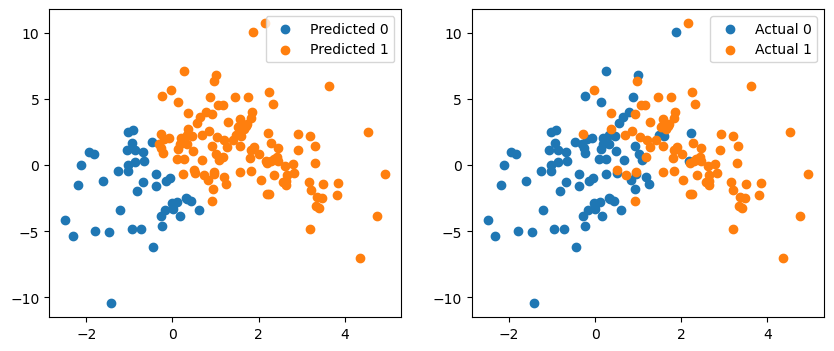

In [167]:
# Now we predict from the X_test
trace = idata.sample(draws = 5000)
def sample_posterior(X_test, Y_test, trace):
    with pm.Model(coords = coords):
        ann_input, ann_output = X_test, Y_test
        wi1 = pm.Flat("wi1", dims=("train_cols", "hidden_layer_1"))
        w12 = pm.Flat("w12", dims=("hidden_layer_1", "hidden_layer_2"))
        w2o = pm.Flat("w2o", dims="hidden_layer_2")

        act1 = pm.math.tanh(pm.math.dot(ann_input, wi1))
        act2 = pm.math.tanh(pm.math.dot(act1, w12))
        act3 = pm.math.sigmoid(pm.math.dot(act2, w2o))

        out = pm.Bernoulli("out", p = act3, observed = ann_output)
        return pm.sample_posterior_predictive(trace)

# set 0.5 as a threshold to classify (<= 0.5 class 0, class 1 otherwise)
pred = sample_posterior(X_test, Y_test, trace)
pred = pred.posterior_predictive["out"].mean(("chain", "draw")) > 0.5
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
ax[0].scatter(X_test[pred == 0, 0], X_test[pred == 0, 1], label = "Predicted 0")
ax[0].scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], label = "Predicted 1")
ax[1].scatter(X_test[Y_test == 0, 0], X_test[Y_test == 0, 1], label = "Actual 0")
ax[1].scatter(X_test[Y_test == 1, 0], X_test[Y_test == 1, 1], label = "Actual 1")
ax[0].legend()
ax[1].legend()

In [168]:
print(f"Accuracy = {(Y_test == pred.values).mean() * 100:.2f}%")

Accuracy = 76.25%


There are some predictions that are not accurate, which usually locate around the middle of the plot, which is understandable becuase those are the overlapping area. Regardless, we can see that variational inference has faster computation compared to MCMC method, which takes a few seconds to finish despite having to do 30,000 iterations. This demonstrates that the variational inference is superior in computation speed (unless we have simple posterior distribution, which MCMC can sample with ease).